In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_score

from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append("/zhouxibin/workspaces/mutations")
from utils.rank import rank_strategy_dictionary
from utils.model import model_name_library
from utils.pipeline import read_sequence
from utils.metrics import read_dms_file

In [14]:
# compute random converage
dms_dir = "../data/dms"
sequence_dir = Path(dms_dir) / "fasta"
gt_dir = Path(dms_dir) / "dms"
results_dir = Path(dms_dir) / "results"

In [15]:
# get all sequence names
sequence_names = [g.stem for g in sequence_dir.glob("*.fa")]

In [28]:
from itertools import product
from tqdm import tqdm
results_list = []
for sequence_name in tqdm(sequence_names):
    sequence_file = sequence_dir / (sequence_name + ".fa")
    gt_file = gt_dir / (sequence_name + ".json")
    sequence = read_sequence(sequence_file)
    dms_df = read_dms_file(gt_file, sequence)
    # select wildtype fitness
    wt_fitness = dms_df[dms_df["sequence"] == ("M"+sequence)]["fitness"].values[0]
    for model_name, rank_strategy in product(["esm2_t12_35M_UR50D_glycosylase"], rank_strategy_dictionary.keys()):
        result_file = results_dir / (sequence_name + "_" + model_name + "_" + rank_strategy + "_.csv")
        # if not (rank_strategy == "esm1v_5" and model_name == "esm2_t48_15B_UR50D"):
        #     continue
        # print(result_file)
        if result_file.exists():
            result_df = pd.read_csv(result_file)
            # print(result_df.head())
            # print(dms_df.head())
            selected_number = max([(result_df["fitness"] > 0).sum(), 50])
            selected_rate = selected_number / result_df.shape[1]
            dms_df["label"] = dms_df["fitness"] > wt_fitness
            result_df = result_df.merge(dms_df, on="sequence", suffixes=("_pred", "_dms"))
            # print(result_df.head())
            # print(result_df.shape)
            # print(result_df.loc[:, ["fitness_pred", "fitness_dms"]].corr("spearman").iloc[0, 1])
            spearman_score = result_df.loc[:, ["fitness_pred", "fitness_dms"]].corr("spearman").iloc[0, 1]
            # break
            # fpr, tpr, threshold = roc_curve(result_df["label"], result_df["fitness_pred"])
            # wt_coord = (threshold>=wt_fitness).argmax(axis=0)+1
            # print(threshold)
            # auc_score = auc(fpr, tpr)
            results_list.append((sequence_name, model_name, rank_strategy, spearman_score, wt_fitness))
            # plt.plot(fpr, tpr, label="auc="+str(auc_score))
            # # plt.scatter(fpr[wt_coord], tpr[wt_coord], marker="o", color="red", label="wt_fitness="+str(wt_fitness))
            # plt.xlabel("False Positive Rate")
            # plt.ylabel("True Positive Rate")
            # plt.title("ROC Curve")
            # plt.legend(loc="lower right")
            # plt.show()
            
            # break
            # mean_precision = []
            # for i in range(10):
            #     # random select selected_number in result_df
            #     random_df = result_df.sample(n=selected_number, random_state=i)
            #     # merge random_df and dms_df
            #     merged_df = random_df.merge(dms_df, on="sequence", suffixes=("_random", "_dms"))
            #     print(merged_df.head())
            #     print(merged_df.shape)
            #     break
            #     precision = (merged_df["fitness_dms"]>wt_fitness).sum() / random_df.shape[0]
            #     mean_precision.append(precision)
            # print(mean_precision)
            # precision = np.mean(mean_precision)
            # break
            # random_precision_list.append((sequence_name, model_name, rank_strategy, precision))
    # break
results_spearman_df = pd.DataFrame(results_list, columns=["sequence_name", "model_name", "rank_strategy", "spearman", "wt_fitness"])
results_spearman_df.head()

100%|██████████| 542/542 [00:33<00:00, 16.32it/s]


,sequence_name,model_name,rank_strategy,spearman,wt_fitness
0,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_1,-0.083172,2.730572
1,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_2,-0.053064,2.730572
2,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_3,-0.005800,2.730572
3,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_4,0.026300,2.730572
4,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_5,-0.016575,2.730572


In [29]:
results_spearman_df.to_csv("./6_data/results_spearman_df.csv")


In [33]:
from itertools import product
from tqdm import tqdm
results_list = []
for sequence_name in tqdm(sequence_names):
    sequence_file = sequence_dir / (sequence_name + ".fa")
    gt_file = gt_dir / (sequence_name + ".json")
    sequence = read_sequence(sequence_file)
    dms_df = read_dms_file(gt_file, sequence)
    # select wildtype fitness
    wt_fitness = dms_df[dms_df["sequence"] == ("M"+sequence)]["fitness"].values[0]
    count = 0
    for model_name, rank_strategy in product(["esm2_t12_35M_UR50D_glycosylase"], rank_strategy_dictionary.keys()):
        if rank_strategy == "AR_5":
            continue
        result_file = results_dir / (sequence_name + "_" + model_name + "_" + rank_strategy + "_.csv")
        # if not (rank_strategy == "esm1v_5" and model_name == "esm2_t48_15B_UR50D"):
        #     continue
        # print(result_file)
        if result_file.exists():
            try:
                result_df = pd.read_csv(result_file)
            except:
                print(result_file)
                with open(result_file, "r") as f:
                    print(f.read())
                break
            # print(result_df.head())
            # print(dms_df.head())
            selected_number = max([(result_df["fitness"] > 0).sum(), 50])
            selected_rate = selected_number / result_df.shape[1]
            dms_df["label"] = dms_df["fitness"] > wt_fitness
            result_df = result_df.merge(dms_df, on="sequence", suffixes=("_pred", "_dms"))
            # print(result_df.head())
            # print(result_df.shape)
            fpr, tpr, threshold = roc_curve(result_df["label"], result_df["fitness_pred"])
            # wt_coord = (threshold>=wt_fitness).argmax(axis=0)+1
            # print(threshold)
            auc_score = auc(fpr, tpr)
            results_list.append((sequence_name, model_name, rank_strategy, fpr, tpr, threshold, auc_score, wt_fitness))
            # plt.plot(fpr, tpr, label="auc="+str(auc_score))
            # # plt.scatter(fpr[wt_coord], tpr[wt_coord], marker="o", color="red", label="wt_fitness="+str(wt_fitness))
            # plt.xlabel("False Positive Rate")
            # plt.ylabel("True Positive Rate")
            # plt.title("ROC Curve")
            # plt.legend(loc="lower right")
            # plt.show()
            
            # break
            # mean_precision = []
            # for i in range(10):
            #     # random select selected_number in result_df
            #     random_df = result_df.sample(n=selected_number, random_state=i)
            #     # merge random_df and dms_df
            #     merged_df = random_df.merge(dms_df, on="sequence", suffixes=("_random", "_dms"))
            #     print(merged_df.head())
            #     print(merged_df.shape)
            #     break
            #     precision = (merged_df["fitness_dms"]>wt_fitness).sum() / random_df.shape[0]
            #     mean_precision.append(precision)
            # print(mean_precision)
            # precision = np.mean(mean_precision)
            # break
            # random_precision_list.append((sequence_name, model_name, rank_strategy, precision))
    # break
results_auc_df = pd.DataFrame(results_list, columns=["sequence_name", "model_name", "rank_strategy", "fpr", "tpr", "threshold", "auc_score", "wt_fitness"])
results_auc_df.head()

100%|██████████| 542/542 [01:06<00:00,  8.09it/s]


,sequence_name,model_name,rank_strategy,fpr,tpr,threshold,auc_score,wt_fitness
0,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_1,"[0.0, 0.002150537634408602, 0.0107526881720430...","[0.0, 0.0, 0.0, 0.0029585798816568047, 0.00295...","[3.070392370223999, 2.070392370223999, 1.95279...",0.490475,2.730572
1,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_2,"[0.0, 0.002150537634408602, 0.0021505376344086...","[0.0, 0.0, 0.0029585798816568047, 0.0029585798...","[9.440492630004883, 8.440492630004883, 7.93924...",0.482624,2.730572
2,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_3,"[0.0, 0.002150537634408602, 0.0021505376344086...","[0.0, 0.0, 0.0029585798816568047, 0.0029585798...","[7.165665626525879, 6.165665626525879, 5.71375...",0.497290,2.730572
3,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_4,"[0.0, 0.002150537634408602, 0.0021505376344086...","[0.0, 0.0, 0.0029585798816568047, 0.0029585798...","[7.444335460662842, 6.444335460662842, 5.46381...",0.518649,2.730572
4,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_5,"[0.0, 0.0, 0.004301075268817204, 0.00430107526...","[0.0, 0.0029585798816568047, 0.002958579881656...","[7.249311923980713, 6.249311923980713, 5.52891...",0.487377,2.730572


In [35]:
results_auc_df.to_csv("./6_data/results_auc_df_esm2_t12_35M_UR50D_glycosylase.csv", index=False)


In [26]:
from itertools import product
from tqdm import tqdm
results_list = []
for sequence_name in tqdm(sequence_names):
    sequence_file = sequence_dir / (sequence_name + ".fa")
    gt_file = gt_dir / (sequence_name + ".json")
    sequence = read_sequence(sequence_file)
    dms_df = read_dms_file(gt_file, sequence)
    # select wildtype fitness
    wt_fitness = dms_df[dms_df["sequence"] == ("M"+sequence)]["fitness"].values[0]
    for model_name, rank_strategy in product(["esm2_t12_35M_UR50D_glycosylase"], rank_strategy_dictionary.keys()):
        if rank_strategy == "AR_5":
            continue
        result_file = results_dir / (sequence_name + "_" + model_name + "_" + rank_strategy + "_.csv")
        # if not (rank_strategy == "esm1v_5" and model_name == "esm2_t48_15B_UR50D"):
        #     continue
        # print(result_file)
        if result_file.exists():
            try:
                result_df = pd.read_csv(result_file)
            except:
                print(result_file)
                with open(result_file, "r") as f:
                    print(f.read())
                # break
                continue
            # print(result_df.head())
            # print(dms_df.head())
            selected_number = max([(result_df["fitness"] > 0).sum(), 50])
            # selected_number = 50
            # top selected_number set to 1, others set to 0
            result_df["label"] = result_df["fitness"] > 0
            result_df["label"][:selected_number] = 1
            result_df["label"][selected_number:] = 0
            result_df["label"] = result_df["label"].astype(bool)
            # print(result_df["label"].sum(), selected_number)
            # selected_rate = selected_number / result_df.shape[1]
            dms_df["label"] = dms_df["fitness"] > wt_fitness
            result_df = result_df.merge(dms_df, on="sequence", suffixes=("_pred", "_dms"))
            # print(result_df.head())
            # print(result_df.shape)
            # print(result_df["fitness_pred"]>0)
            # print(result_df["label"])
            precision = precision_score(result_df["label_dms"], result_df["label_pred"])
            # print(precision)
            # break
            # fpr, tpr, threshold = roc_curve(result_df["label"], result_df["fitness_pred"])
            # wt_coord = (threshold>=wt_fitness).argmax(axis=0)+1
            # print(threshold)
            # auc_score = auc(fpr, tpr)
            results_list.append((sequence_name, model_name, rank_strategy, precision))
            # plt.plot(fpr, tpr, label="auc="+str(auc_score))
            # # plt.scatter(fpr[wt_coord], tpr[wt_coord], marker="o", color="red", label="wt_fitness="+str(wt_fitness))
            # plt.xlabel("False Positive Rate")
            # plt.ylabel("True Positive Rate")
            # plt.title("ROC Curve")
            # plt.legend(loc="lower right")
            # plt.show()
            
            # break
            # mean_precision = []
            # for i in range(10):
            #     # random select selected_number in result_df
            #     random_df = result_df.sample(n=selected_number, random_state=i)
            #     # merge random_df and dms_df
            #     merged_df = random_df.merge(dms_df, on="sequence", suffixes=("_random", "_dms"))
            #     print(merged_df.head())
            #     print(merged_df.shape)
            #     break
            #     precision = (merged_df["fitness_dms"]>wt_fitness).sum() / random_df.shape[0]
            #     mean_precision.append(precision)
            # print(mean_precision)
            # precision = np.mean(mean_precision)
            # random_precision_list.append((sequence_name, model_name, rank_strategy, precision))
    # break
results_precision_df = pd.DataFrame(results_list, columns=["sequence_name", "model_name", "rank_strategy", "precision"])
results_precision_df.head()

100%|██████████| 542/542 [00:37<00:00, 14.32it/s]


,sequence_name,model_name,rank_strategy,precision
0,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_1,0.432143
1,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_2,0.390052
2,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_3,0.419355
3,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_4,0.465217
4,2BTH.pdb,esm2_t12_35M_UR50D_glycosylase,esm1v_5,0.417323


In [27]:
# results_precision_df.to_csv("./6_data/results_precision_df_esm2_t12_35M_UR50D_glycosylase_only50.csv", index=False)
results_precision_df.to_csv("./6_data/results_precision_df_esm2_t12_35M_UR50D_glycosylase.csv", index=False)


In [12]:
# plot_type = "spearman"
plot_type = "auc"

In [13]:
if plot_type == "auc":
    results_auc_df_finetune = pd.read_csv("./6_data/results_auc_df_esm2_t12_35M_UR50D_glycosylase.csv")
    results_auc_df = pd.read_csv("./5_data/results_auc_df.csv")
    results_auc_df_concat = pd.concat([results_auc_df, results_auc_df_finetune])
    heatmap_df = results_auc_df_concat.groupby(["model_name", "rank_strategy"])["auc_score"].mean()
elif plot_type == "precision":
    results_precision_df_finetune = pd.read_csv("./6_data/results_precision_df_esm2_t12_35M_UR50D_glycosylase.csv")
    results_precision_df = pd.read_csv("./5_data/results_precision_df.csv")
    results_precision_df_concat = pd.concat([results_precision_df, results_precision_df_finetune])
    heatmap_df = results_precision_df_concat.groupby(["model_name", "rank_strategy"])["precision"].mean()
elif plot_type == "spearman":
    results_spearman_df_finetune = pd.read_csv("./6_data/results_spearman_df_esm2_t12_35M_UR50D_glycosylase.csv")
    results_spearman_df = pd.read_csv("./5_data/results_spearman_df.csv")
    results_spearman_df_concat = pd.concat([results_spearman_df, results_spearman_df_finetune])
    results_spearman_df_concat["spearman"] = results_spearman_df_concat["spearman"].abs()
    heatmap_df = results_spearman_df_concat.groupby(["model_name", "rank_strategy"])["spearman"].mean()


In [14]:
temp_model_name_library = ["esm2_t12_35M_UR50D_glycosylase", "esm2_t12_35M_UR50D", "esm2_t33_650M_UR50D"]
heatmap_np = np.zeros((len(temp_model_name_library), len(rank_strategy_dictionary)-1))
model_name_marginal = np.zeros(len(temp_model_name_library))
rank_strategy_marginal = np.zeros(len(rank_strategy_dictionary)-1)
for model_name in temp_model_name_library:
    for rank_strategy in list(rank_strategy_dictionary.keys())[:-1]:
        if model_name != "regression_transformer":
            heatmap_np[temp_model_name_library.index(model_name), list(rank_strategy_dictionary.keys())[:-1].index(rank_strategy)] = heatmap_df[model_name][rank_strategy]
if plot_type == "auc":
    fill_num = 0.5
elif plot_type == "spearman":
    fill_num = 0
heatmap_np = np.concatenate([np.full((1, heatmap_np.shape[1]), fill_num), heatmap_np], axis=0)
temp_model_name_library.insert(0, "random")
model_name_marginal = heatmap_np.mean(axis=1)
rank_strategy_marginal = heatmap_np.mean(axis=0)


print(heatmap_np.shape)
print(model_name_marginal.shape)
print(rank_strategy_marginal.shape)


(4, 9)
(4,)
(9,)


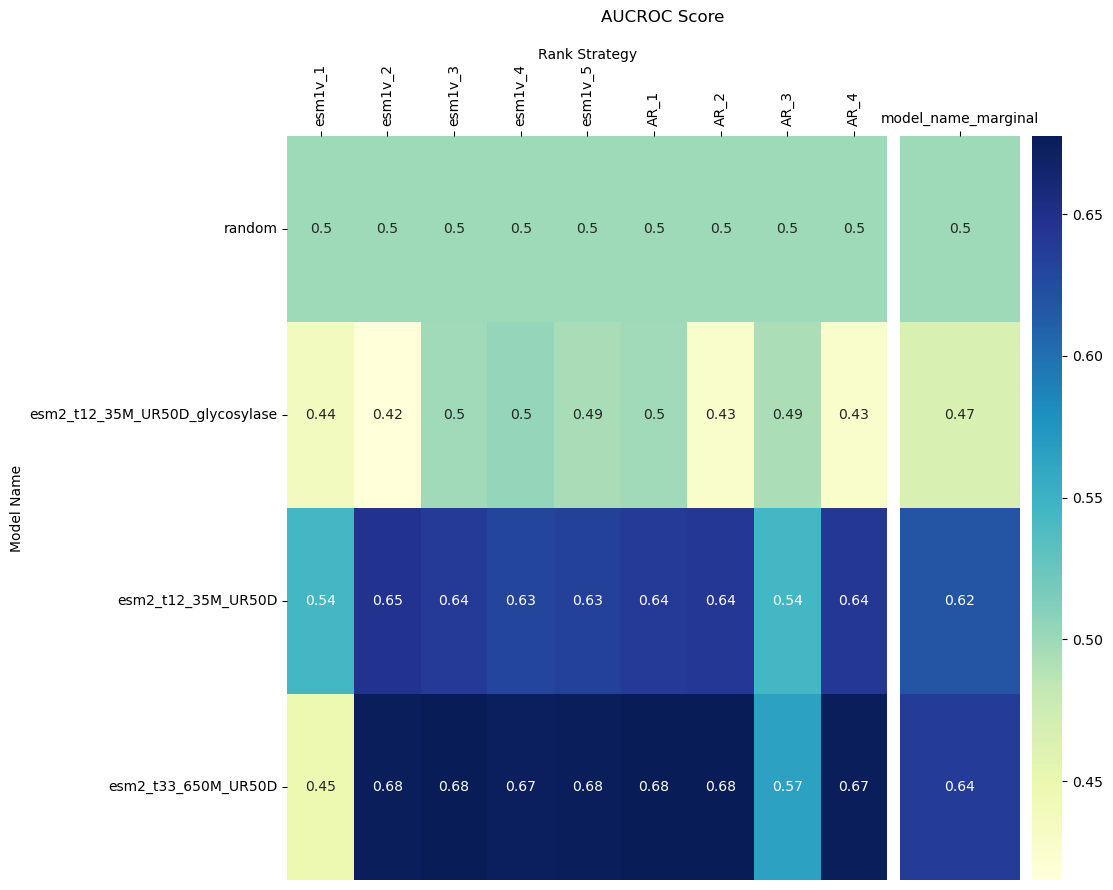

In [16]:
# plot heatmap and marginal score
fig = plt.figure(figsize=(10, 10))
# grid = plt.GridSpec(4, 3, hspace=1.0, wspace=0.2)
grid = plt.GridSpec(2, 3, hspace=0.05, wspace=0.05, width_ratios=[1, 0.2, 0.05], height_ratios=[0.01, 1])

ax_main = fig.add_subplot(grid[1, 0])
ax_right = fig.add_subplot(grid[1, 1], xticklabels=[], yticklabels=[])
# ax_bottom = fig.add_subplot(grid[2, 0], xticklabels=[], yticklabels=[])
ax_colorbar = fig.add_subplot(grid[1:, 2], xticklabels=[], yticklabels=[])
vmin = min(heatmap_np.min(), min(model_name_marginal))
vmax = max(heatmap_np.max(), max(model_name_marginal))
sns.heatmap(heatmap_np, annot=True, ax=ax_main, xticklabels=list(rank_strategy_dictionary.keys())[:-1], yticklabels=temp_model_name_library, cmap="YlGnBu", vmin=vmin, vmax=vmax, cbar=False)
ax_main.xaxis.tick_top()
ax_main.xaxis.set_tick_params(rotation=90)

ax_main.set_xlabel("Rank Strategy")
ax_main.xaxis.set_label_position('top')
ax_main.set_ylabel("Model Name")
sns.heatmap(pd.DataFrame(model_name_marginal), annot=True, ax=ax_right, yticklabels=False, xticklabels=["model_name_marginal"], cmap="YlGnBu", vmin=vmin, vmax=vmax, cbar=False)
ax_right.xaxis.tick_top()
# sns.heatmap(pd.DataFrame(rank_strategy_marginal).T, annot=True, ax=ax_bottom, xticklabels=list(rank_strategy_dictionary.keys())[:-1], yticklabels=["rank_strategy_marginal"], cmap="YlGnBu")
norm = plt.Normalize(vmin, vmax)  
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='YlGnBu'), cax=ax_colorbar)
for spine in ax_colorbar.spines.values(): 
    spine.set_visible(False)
if plot_type == "auc":
    plt.suptitle("AUCROC Score")
    fig.savefig("./6_data/heatmap_auc.png", dpi=300, bbox_inches='tight')
    fig.savefig("./6_data/heatmap_auc.tiff", dpi=300, bbox_inches='tight')
elif plot_type == "precision":
    plt.suptitle("Precision Score")
    fig.savefig("./6_data/heatmap_precision.png", dpi=300, bbox_inches='tight')
    fig.savefig("./6_data/heatmap_precision.tiff", dpi=300, bbox_inches='tight')
elif plot_type == "spearman":
    plt.suptitle("Speraman Correlation")
    fig.savefig("./6_data/heatmap_spearman.png", dpi=300, bbox_inches='tight')
    fig.savefig("./6_data/heatmap_spearman.tiff", dpi=300, bbox_inches='tight')